ValueError: autodetected range of [nan, nan] is not finite

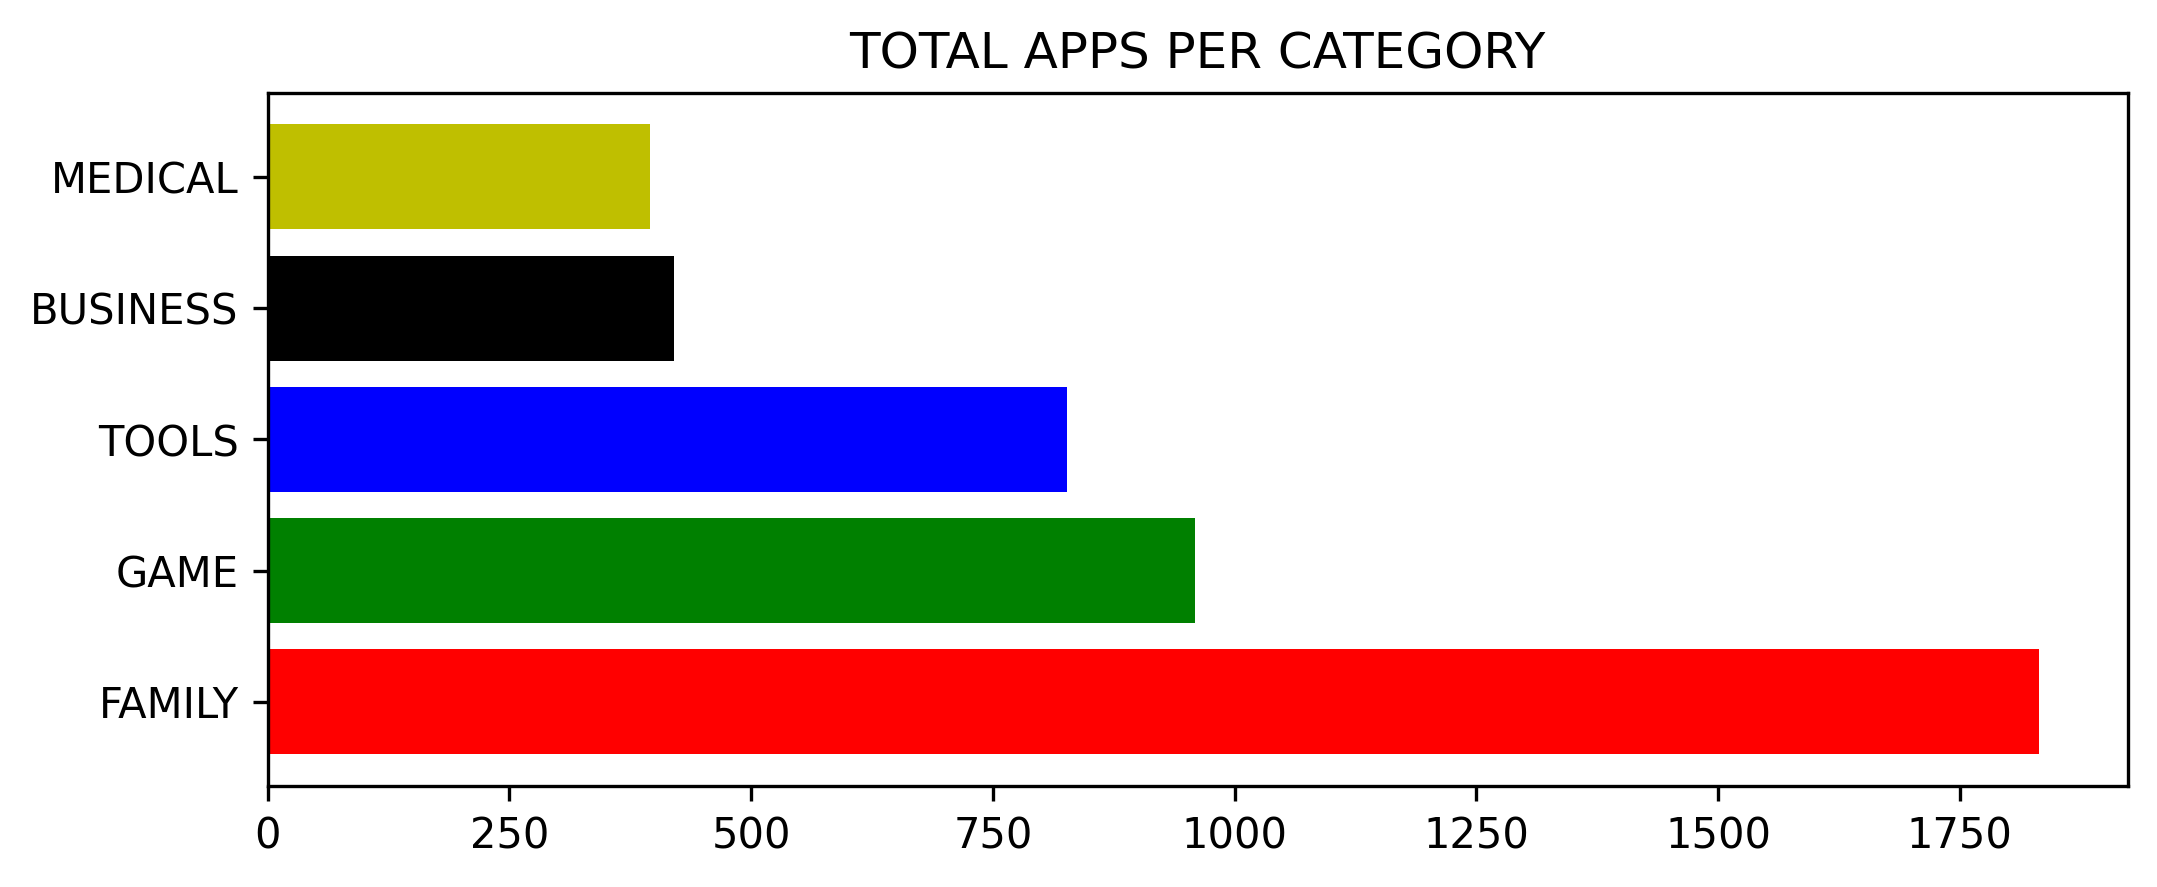

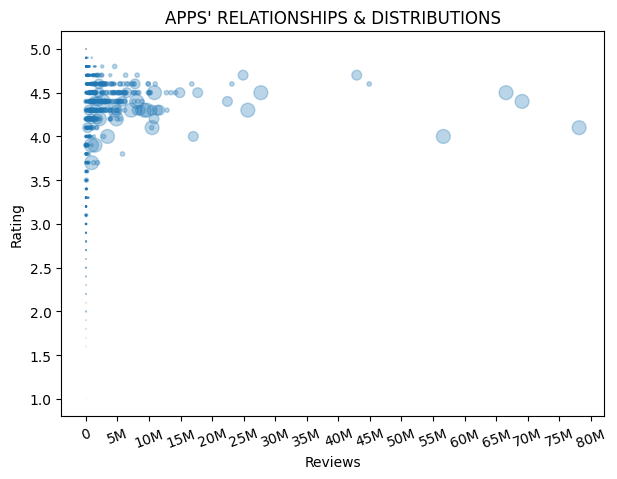

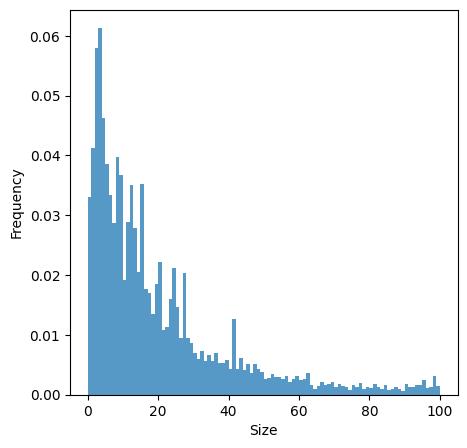

In [1]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64



playstore = pd.read_csv("data/googleplaystore.csv")

playstore.drop_duplicates(subset='App', keep="first", inplace=True)

# bagian ini untuk menghapus row 10472 karena nilai data tersebut tidak tersimpan pada kolom yang benar
playstore.drop([10472], inplace=True)

playstore.Category = playstore.Category.astype('category')

playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',', ''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+', ''))

# Bagian ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini
playstore['Size'].replace('Varies with device', np.nan, inplace=True)
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) *
                  playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
                  .fillna(1)
                  .replace(['k', 'M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')[
                         'Size'].transform('mean'), inplace=True)

playstore.Price = playstore.Price.apply(lambda x: x.replace('$', ''))
playstore.Price = playstore.Price.astype('float')

# Ubah tipe data Reviews, Size, Installs ke dalam tipe data integer
playstore[['Reviews', 'Size', 'Installs']] = playstore[[
    'Reviews', 'Size', 'Installs']].astype('int')


df2 = playstore.copy()

# Statistik
top_category = pd.crosstab(index=df2['Category'],
                            columns='freq',
                            values=df2['App'],
                            aggfunc='count').sort_values(by='freq', ascending=False).reset_index()
# Dictionary stats digunakan untuk menyimpan beberapa data yang digunakan untuk menampilkan nilai di value box dan tabel
stats = {
    'most_categories': top_category.iloc[0, 0],
    'total': top_category.iloc[0, 1],
    'rev_table': df2[['Category', 'App', 'Reviews', 'Rating']].groupby(by=['Category', 'App'])
    .agg({'Reviews': 'sum', 'Rating': 'mean'})
    .sort_values(by='Reviews', ascending=False)
    .head(10).reset_index().to_html(classes=['table thead-light table-striped table-bordered table-hover table-sm'])
}

# Bar Plot
cat_order = df2.groupby('Category', as_index=False).agg({'App': 'count'}).rename(
    {'Category': 'Total'}, axis=1).sort_values(by='App', ascending=False).head()
X = cat_order['Total'].values
Y = cat_order['App'].values
my_colors = ["r", "g", "b", "k", "y", "m", "c"]
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8, 3), dpi=300)
fig.add_subplot()
# bagian ini digunakan untuk membuat bar plot
plt.barh(X, Y, color=my_colors)
plt.title('TOTAL APPS PER CATEGORY')
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png', bbox_inches="tight")

# bagian ini digunakan untuk mengconvert matplotlib png ke base64 agar dapat ditampilkan ke template html
figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
# variabel result akan dimasukkan ke dalam parameter di fungsi render_template() agar dapat ditampilkan di
# halaman html
result = str(figdata_png)[2:-1]

# Scatter Plot
df3 = playstore.copy()
X = df3['Reviews'].values  # axis x
Y = df3['Rating'].values  # axis y
# ukuran besar/kecilnya lingkaran scatter plot
# ukuran besar/kecilnya lingkaran scatter plot
area = playstore['Installs'].values/10000000
fig = plt.figure(figsize=(7, 5))
fig.add_subplot()
# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x=X, y=Y, s=area, alpha=0.3)
plt.title("APPS' RELATIONSHIPS & DISTRIBUTIONS")
plt.xlabel('Reviews')
plt.xticks([0, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000, 35000000, 40000000, 45000000, 50000000, 55000000, 60000000, 65000000, 70000000, 75000000, 80000000],
            ['0', '5M', '10M', '15M', '20M', '25M', '30M', '35M', '40M', '45M', '50M', '55M', '60M', '65M', '70M', '75M', '80M'], rotation=20)
plt.yticks([1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5.])
plt.ylabel('Rating')
plt.savefig('rev_rat.png', bbox_inches="tight")

# bagian ini digunakan untuk mengconvert scatter png ke base64 agar dapat ditampilkan ke template html

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result2 = str(figdata_png)[2:-1]

# Histogram Size Distribution
X = (df2['Size']/1000000).values
fig = plt.figure(figsize=(5, 5))
fig.add_subplot()
plt.hist(X, bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png', bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result3 = str(figdata_png)[2:-1]

# Buatlah sebuah plot yang menampilkan insight di dalam data
counts, bins = np.histogram(df2["Rating"])
plt.hist(bins[:-1], bins, weights=counts)

# Tambahkan hasil result plot pada fungsi render_template()

In [9]:
np.histogram(df2["Rating"].dropna())

(array([  17,   18,   39,   73,  132,  439,  833, 1493, 3450, 1702],
       dtype=int64),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]))